## Q1

In [1]:
import pandas as pd

In [2]:
blood_transfusion = pd.read_csv('data/blood_transfusion.csv')
target_name = "Class"
data = blood_transfusion.drop(columns=target_name)
target = blood_transfusion[target_name]

In [3]:
blood_transfusion.head()

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,donated
1,0,13,3250,28,donated
2,1,16,4000,35,donated
3,2,20,5000,45,donated
4,1,24,6000,77,not donated


In [4]:
target.value_counts()

not donated    570
donated        178
Name: Class, dtype: int64

In [5]:
target.unique()

array(['donated', 'not donated'], dtype=object)

In [6]:
target.value_counts(normalize=True)

not donated    0.762032
donated        0.237968
Name: Class, dtype: float64

## Q2

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [8]:
dummy = DummyClassifier(strategy="most_frequent")

In [9]:
dummy.fit(data, target)

DummyClassifier(strategy='most_frequent')

In [10]:
dummy.score(data, target)

0.7620320855614974

In [11]:
cv = cross_validate(dummy, data, target)

In [12]:
cv

{'fit_time': array([0.0009973 , 0.00099659, 0.00100994, 0.00099754, 0.00099707]),
 'score_time': array([0.00099826, 0.        , 0.00099015, 0.00099659, 0.        ]),
 'test_score': array([0.76      , 0.76      , 0.76      , 0.76510067, 0.76510067])}

In [13]:
cv["test_score"].mean()

0.7620402684563758

## Q2 Solution

In [14]:
dummy = DummyClassifier(strategy="most_frequent")
scores = cross_val_score(dummy, data, target, cv=10)
scores.mean()

0.762054054054054

This is not a surprise to get a score a high as ~75%. This is due to the class imbalanced nature of the dataset: always predicting not donated class will be correct ~75% of the time since this the natural proportion of samples belonging to this class in the data.

## Q3

In [15]:
scores = cross_val_score(dummy, data, target, cv=10, scoring="balanced_accuracy")
scores.mean()

0.5

In this case, the score is corrected such that such a dummy approach will give a score of 50%. You can learn more about how balanced_accuracy is computed in the scikit-learn documentation. balanced_accuracy therefore makes it easier to distinguish good from bad classifier on imbalanced classification problems.

## Q4

We will use a sklearn.neighbors.KNeighborsClassifier for the remainder of this quiz.

Why is it relevant to add a preprocessing step to scale the data using a StandardScaler when working with a KNeighborsClassifier?

Answer:
k-nearest neighbors is based on computing some distances. Features need to be normalized to contribute approximately equally to the distance computation.

Computing distances on scaled or un-scaled data takes similar time but the resulting distance values could be very different and therefore ordering of which sample is a closest neighbor to which sample also. For instance: if you have two variables A and B where A has values which vary between 0 and 1000000 (e.g. the price of a house in euros) and B is a variable that varies between 0 and 30 (e.g. the average outside air temperature in Celsius degrees), then computing distances between rows of such a database will be mostly impacted by the differences in values of the A column and the values of B column will be comparatively ignored. If one applies StandardScaler to such a database, both the values of A and B will be approximately between -3 and 3 and the neighbor structure will be impacted by both variables.

## Q5

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [17]:
model = make_pipeline(StandardScaler(), KNeighborsClassifier())

In [18]:
model.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

## Q6

In [19]:
cv = cross_validate(model, data, target, cv=10, scoring="balanced_accuracy", return_train_score=True)
cv

{'fit_time': array([0.00611377, 0.00405407, 0.00691772, 0.0030086 , 0.00404572,
        0.00306129, 0.00299263, 0.00395489, 0.00398898, 0.00401878]),
 'score_time': array([0.00399685, 0.0039897 , 0.0049839 , 0.00405049, 0.00399733,
        0.00398827, 0.00405812, 0.00399709, 0.0030303 , 0.00299335]),
 'test_score': array([0.56871345, 0.45321637, 0.46345029, 0.48391813, 0.48245614,
        0.5       , 0.56140351, 0.74561404, 0.50309598, 0.52941176]),
 'train_score': array([0.7160575 , 0.70066399, 0.68093933, 0.70846126, 0.70788865,
        0.71706262, 0.70026194, 0.67076023, 0.69338806, 0.69898781])}

In [20]:
print(f"Test score: {cv['test_score'].mean():.2f} Train score: {cv['train_score'].mean():.2f}")

Test score: 0.53 Train score: 0.70


## Q6 Solution

In [21]:
cv_results = cross_validate(
    model, data, target, cv=10, scoring="balanced_accuracy", return_train_score=True
)
cv_results = pd.DataFrame(cv_results)
cv_results[["train_score", "test_score"]].mean()

train_score    0.699447
test_score     0.529128
dtype: float64

We see that the gap between train and test scores is large. In addition, the average score of on the training sets is good while the average scores on the testing sets is really bad. They are the signs of a overfitting model.

## Q7

In [25]:
from sklearn.model_selection import validation_curve

In [37]:
param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500]

train_scores, test_scores = validation_curve(
    model, data, target, param_name="kneighborsclassifier__n_neighbors",
    param_range=param_range, scoring="balanced_accuracy", n_jobs=2, cv=5)

In [30]:
import matplotlib.pyplot as plt

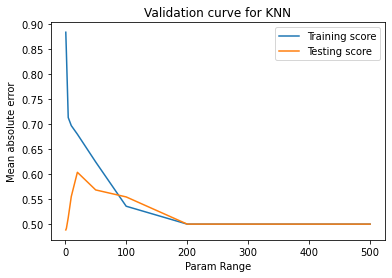

In [38]:
plt.plot(param_range, train_scores.mean(axis=1), label="Training score")
plt.plot(param_range, test_scores.mean(axis=1), label="Testing score")
plt.legend()

plt.xlabel("Param Range")
plt.ylabel("Mean absolute error")
_ = plt.title("Validation curve for KNN")

## Q7 Solution

Text(0.5, 1.0, 'Validation curve of K-nearest neighbors')

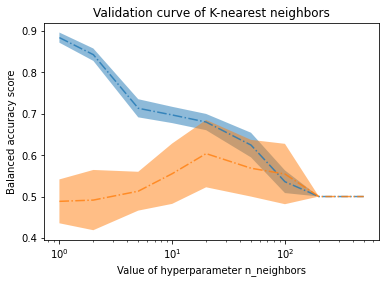

In [36]:
param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500]
param_name = "kneighborsclassifier__n_neighbors"
train_scores, test_scores = validation_curve(
    model, data, target, param_name=param_name, param_range=param_range, cv=5,
    n_jobs=2, scoring="balanced_accuracy")

_, ax = plt.subplots()
for name, scores in zip(
    ["Training score", "Testing score"], [train_scores, test_scores]
):
    ax.plot(
        param_range, scores.mean(axis=1), linestyle="-.", label=name,
        alpha=0.8)
    ax.fill_between(
        param_range, scores.mean(axis=1) - scores.std(axis=1),
        scores.mean(axis=1) + scores.std(axis=1),
        alpha=0.5, label=f"std. dev. {name.lower()}")

ax.set_xticks(param_range)
ax.set_xscale("log")
ax.set_xlabel("Value of hyperparameter n_neighbors")
ax.set_ylabel("Balanced accuracy score")
ax.set_title("Validation curve of K-nearest neighbors")

## Q8 Solution

Answer:
The model overfits for a range of n_neighbors values between 1 to 10 

Overfitting happens when the gap between train and test scores is high and that the test score is low. When n_neighbors is low, the model looks at small number of data points around the test points of interest. In this case the model is too flexible: it is sensible to noise rather than the underlying structure of the data.

## Q9 Solution

Answer: The model best generalizes for a range of n_neighbors values between 10 to 100

Generalization happens when the gap between train and test scores is relatively low and that the test scores is maximum. In our case, the range between 20 to 50 neighbors seems the best. Indeed, for 20 neighbors, the gap between train and test scores is larger than with 50 neighbors; however the test score is better with 20 neighbors.

Considering an intermediate value for n_neighbors makes it possible to limit overfitting by averaging out the influence of a few noisy samples. On the other hand, the model can also avoid underfitting by focusing its decision on the details of a region of interest close to the test sample. The optimum value for n_neighbors is typically very dataset dependent and can be influenced by the choice of the distance metric, the scaling of the features, the presence of noisy sample, the balance between classes.

Finally note while k-nearest neighbors is useful baseline, it can be to slow to predict on large datasets with many samples and features and practitioners would instead favor other models such as gradient boosted trees for instance. On the particular dataset used for this quiz, the best accuracy achieved by the nearest neighbors model does not seem to be high enough to make it useful.